# DrivenData Machine Learning with a Heart
Detect heart disease from patient cardiovascular dataset. The objective of this project is to predict the binary class, `heart_disease_present`, which represents whether or not a patient has heart disease:
- `0` represents no heart disease present
- `1` represents heart disease present

DrivenData [competition info here](https://www.drivendata.org/competitions/54/machine-learning-with-a-heart/page/107/); data provided by [Cleveland Heart Disease Database](http://archive.ics.uci.edu/ml/datasets/statlog+(heart)) via the UCI Machine Learning repository

- Invert values for `num_major_vessels` (0-3) values should change to (3-0) ie 1 changes to 2, 0, changes to 3
- Invert values for `ST_depression` - values represent where ST segment is abnormally low below baseline

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, OneHotEncoder, KBinsDiscretizer

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score

%matplotlib inline

In [2]:
df = pd.read_csv('https://s3.amazonaws.com/drivendata/data/54/public/train_values.csv')
labels = pd.read_csv('https://s3.amazonaws.com/drivendata/data/54/public/train_labels.csv')
labels.drop(['patient_id'],axis=1,inplace=True)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=42)

In [4]:
X_train.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
117,9dqkpy,1,reversible_defect,110,4,0,0,2,172,0.0,1,41,158,0
65,nck22c,1,reversible_defect,126,4,0,0,2,282,0.0,1,35,156,1
67,f70grj,2,normal,115,4,0,0,0,303,1.2,1,43,181,0
31,z7xkou,2,reversible_defect,150,4,3,0,2,225,1.0,0,65,114,0
12,mpggsq,1,normal,140,3,0,0,0,335,0.0,1,64,158,0


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 117 to 102
Data columns (total 14 columns):
patient_id                              144 non-null object
slope_of_peak_exercise_st_segment       144 non-null int64
thal                                    144 non-null object
resting_blood_pressure                  144 non-null int64
chest_pain_type                         144 non-null int64
num_major_vessels                       144 non-null int64
fasting_blood_sugar_gt_120_mg_per_dl    144 non-null int64
resting_ekg_results                     144 non-null int64
serum_cholesterol_mg_per_dl             144 non-null int64
oldpeak_eq_st_depression                144 non-null float64
sex                                     144 non-null int64
age                                     144 non-null int64
max_heart_rate_achieved                 144 non-null int64
exercise_induced_angina                 144 non-null int64
dtypes: float64(1), int64(11), object(2)
memory usage: 16.9+ KB

In [6]:
X_train.drop(['patient_id'],axis=1,inplace=True)
X_train.loc[:,'thal'] = X_train.loc[:,'thal'].astype('category')
#X_train.loc[:,'chest_pain_type'] = X_train.loc[:,'chest_pain_type'].astype('category')
X_train['thal'].value_counts()

/Applications/anaconda/envs/python3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Applications/anaconda/envs/python3/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


normal               79
reversible_defect    58
fixed_defect          7
Name: thal, dtype: int64

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 117 to 102
Data columns (total 13 columns):
slope_of_peak_exercise_st_segment       144 non-null int64
thal                                    144 non-null category
resting_blood_pressure                  144 non-null int64
chest_pain_type                         144 non-null int64
num_major_vessels                       144 non-null int64
fasting_blood_sugar_gt_120_mg_per_dl    144 non-null int64
resting_ekg_results                     144 non-null int64
serum_cholesterol_mg_per_dl             144 non-null int64
oldpeak_eq_st_depression                144 non-null float64
sex                                     144 non-null int64
age                                     144 non-null int64
max_heart_rate_achieved                 144 non-null int64
exercise_induced_angina                 144 non-null int64
dtypes: category(1), float64(1), int64(11)
memory usage: 14.9 KB


In [8]:
X_train.describe()

,slope_of_peak_exercise_st_segment,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,1.527778,131.472222,3.173611,0.694444,0.166667,1.006944,246.409722,0.960417,0.673611,55.020833,149.694444,0.326389
std,0.636253,17.078160,0.941134,0.977207,0.373979,0.999976,47.140827,1.109981,0.470528,9.004637,22.091443,0.470528
min,1.000000,94.000000,1.000000,0.000000,0.000000,0.000000,126.000000,0.000000,0.000000,34.000000,96.000000,0.000000
25%,1.000000,120.000000,3.000000,0.000000,0.000000,0.000000,212.750000,0.000000,0.000000,48.750000,136.250000,0.000000
50%,1.000000,130.000000,3.000000,0.000000,0.000000,1.500000,245.500000,0.600000,1.000000,56.000000,152.500000,0.000000
75%,2.000000,140.000000,4.000000,1.000000,0.000000,2.000000,277.000000,1.525000,1.000000,62.000000,166.250000,1.000000
max,3.000000,180.000000,4.000000,3.000000,1.000000,2.000000,417.000000,6.200000,1.000000,77.000000,192.000000,1.000000


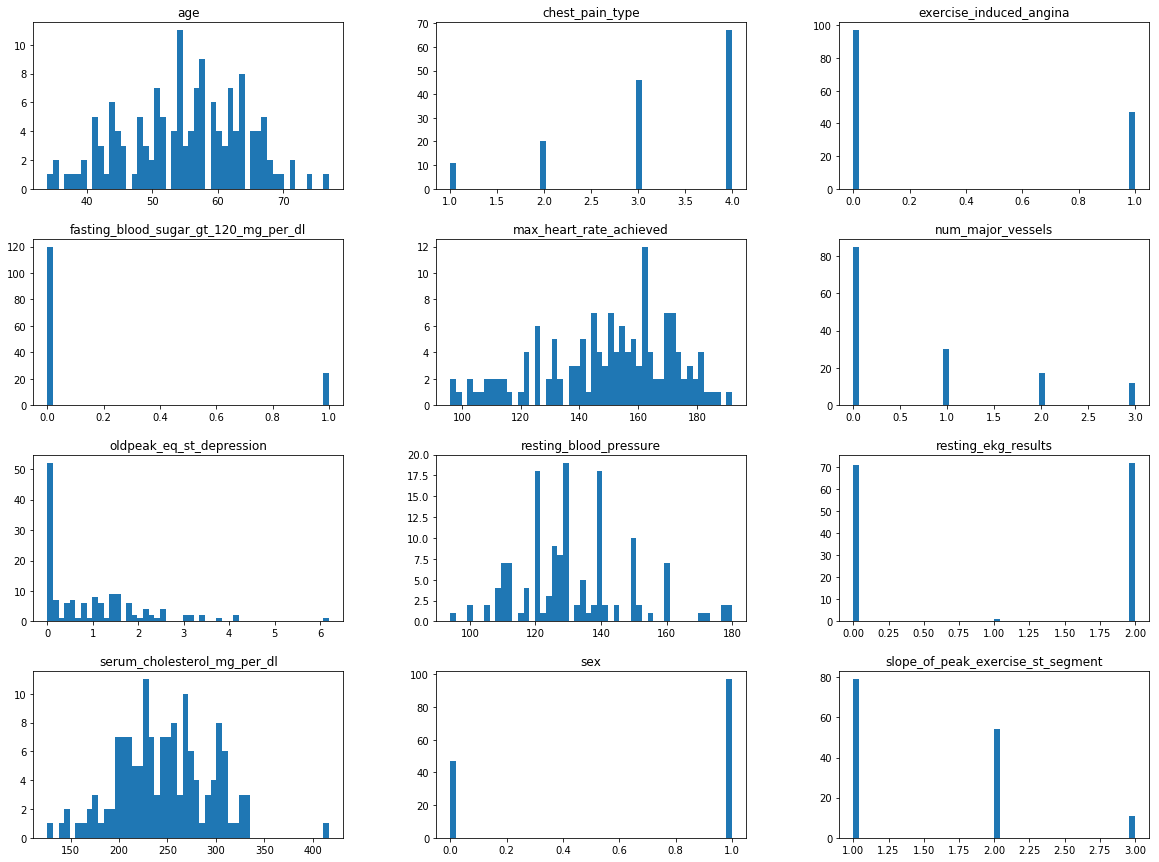

In [9]:
X_train.hist(bins=50, figsize=(20,15),grid=False)
plt.show()

In [10]:
X_train['label'] = y_train

/Applications/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [11]:
def kde_by_label(feature):
    title = feature.replace("_"," ").title()
    fig, axs = plt.subplots(sharey=True,sharex=True,figsize=(15,4))
    X_train.groupby('label')[feature].plot(kind='kde', 
                                           ax=axs,
                                           alpha=0.8,
                                           title=title)
    plt.show()

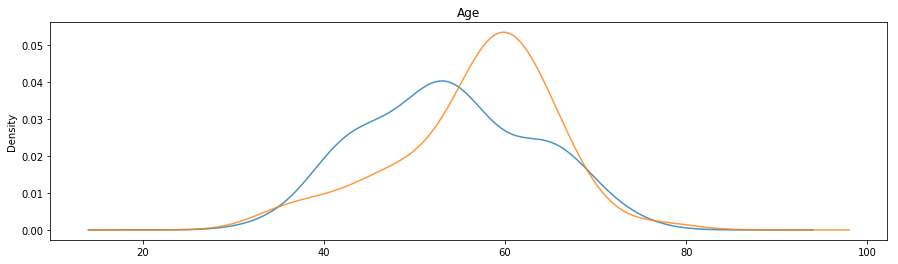

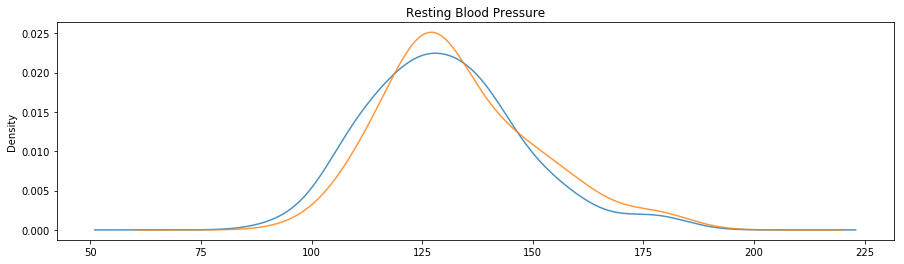

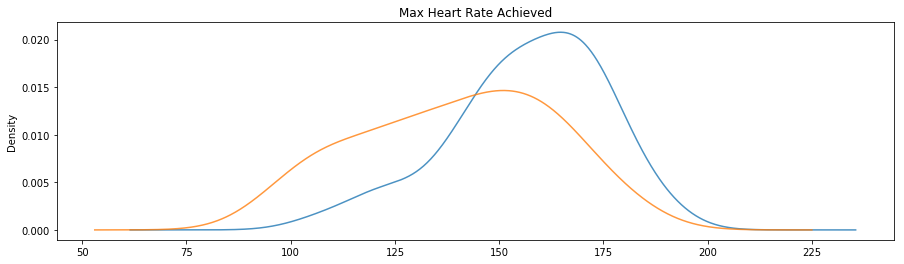

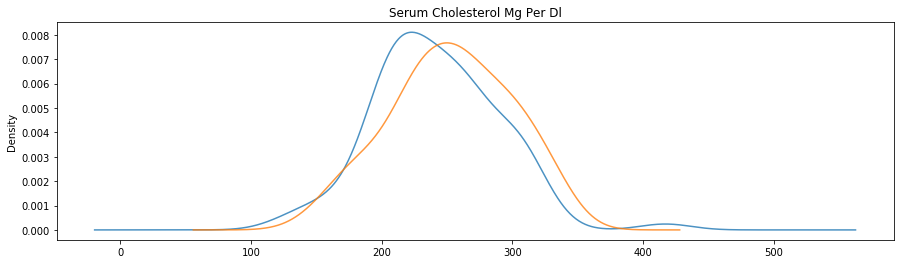

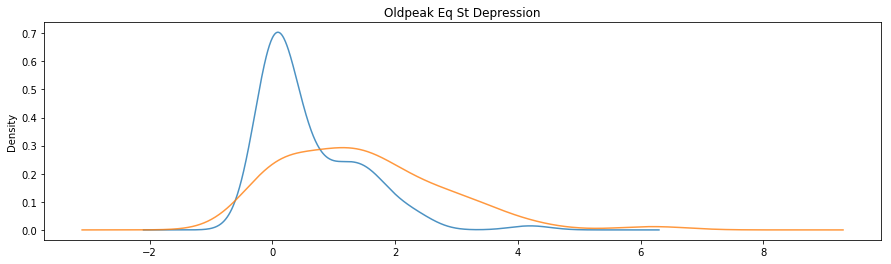

In [12]:
for x in ['age',
          'resting_blood_pressure',
          'max_heart_rate_achieved',
          'serum_cholesterol_mg_per_dl',
          'oldpeak_eq_st_depression',
         ]:
    kde_by_label(x)

- Age: heart disease patients likely to be close to 60
- Resting BP: Females with higher resting BP likely to have heart diease
- Cholesterol: Higher cholesterol slightly more likely to have heart disease
- ST depression greater than 0 likely heart disease patient; consider changing to binary variable


#### Discrete variables

In [13]:
len(X_train[X_train['sex']==0])

47

In [14]:
len(X_train[X_train['sex']==1])

97

In [ ]:
#fig, axs = plt.subplots(ncols=4)
#loc = 0
#for x in X_train:
#    X_train.groupby('label')[x].plot(kind='kde', ax=axs[loc])
#    loc += 1

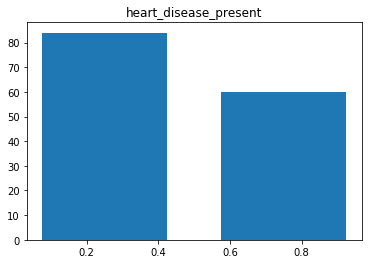

In [15]:
y_train.hist(bins=2,rwidth=.7,grid=False)
plt.show()

In [16]:
X_train = X_train.drop('label',axis=1)

In [17]:
def get_cat_num_labels(df):
    num = []
    cat = []
    for col in df.columns:
        if df[col].dtype == 'float64':
            num.append(col)
        elif df[col].dtype == 'int64':
            num.append(col)
        else:
            cat.append(col)
    return num, cat

In [18]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [19]:
num, cat = get_cat_num_labels(X_train)

In [20]:
num

['slope_of_peak_exercise_st_segment',
 'resting_blood_pressure',
 'chest_pain_type',
 'num_major_vessels',
 'fasting_blood_sugar_gt_120_mg_per_dl',
 'resting_ekg_results',
 'serum_cholesterol_mg_per_dl',
 'oldpeak_eq_st_depression',
 'sex',
 'age',
 'max_heart_rate_achieved',
 'exercise_induced_angina']

In [21]:
num = ['resting_blood_pressure',
       'fasting_blood_sugar_gt_120_mg_per_dl',
       'resting_ekg_results',
       'serum_cholesterol_mg_per_dl',
       'oldpeak_eq_st_depression',
       'age',
       'max_heart_rate_achieved',]

In [22]:
cat

['thal']

In [23]:
cat = ['thal', 
       'chest_pain_type',
       'sex', 
       'exercise_induced_angina',
       'num_major_vessels',
       'resting_ekg_results',
       'fasting_blood_sugar_gt_120_mg_per_dl',
       'slope_of_peak_exercise_st_segment',
      ]

In [24]:
num_pipeline = Pipeline([
    ('df_selector',DataFrameSelector(num)),
    ('Normalizer', MinMaxScaler(feature_range=(0,1))),
])

cat_pipeline = Pipeline([
    ('df_selector',DataFrameSelector(cat)),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])

pipe = Pipeline([('feats',FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline',cat_pipeline),
])),('poly',PolynomialFeatures(2)),
                ])

In [27]:
y_train = y_train['heart_disease_present'].values

In [28]:
X_train = pipe.fit_transform(X_train)

In [35]:
X_train

<144x496 sparse matrix of type '<class 'numpy.float64'>'
	with 15830 stored elements in Compressed Sparse Column format>

In [39]:
X_train.shape

(144, 496)

In [36]:
corr_matrix = X_train.corr()

AttributeError: corr not found

In [37]:
corr_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)

,slope_of_peak_exercise_st_segment,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
slope_of_peak_exercise_st_segment,1,0.1,0.079,0.07,0.069,0.16,-0.039,0.59,0.089,0.19,-0.42,0.21
resting_blood_pressure,0.1,1,0.022,0.033,0.13,0.029,0.19,0.25,-0.091,0.22,-0.054,0.1
chest_pain_type,0.079,0.022,1,0.28,-0.0033,0.058,0.083,-0.016,0.05,0.16,-0.26,0.31
num_major_vessels,0.07,0.033,0.28,1,0.18,0.095,0.13,0.22,0.071,0.34,-0.29,0.2
fasting_blood_sugar_gt_120_mg_per_dl,0.069,0.13,-0.0033,0.18,1,-0.0031,0.014,0.0042,0.11,0.097,0.076,0.0066
resting_ekg_results,0.16,0.029,0.058,0.095,-0.0031,1,0.16,0.14,0.094,0.086,-0.12,0.084
serum_cholesterol_mg_per_dl,-0.039,0.19,0.083,0.13,0.014,0.16,1,-0.035,-0.12,0.19,-0.14,0.16
oldpeak_eq_st_depression,0.59,0.25,-0.016,0.22,0.0042,0.14,-0.035,1,0.059,0.23,-0.32,0.19
sex,0.089,-0.091,0.05,0.071,0.11,0.094,-0.12,0.059,1,-0.14,-0.031,0.23
age,0.19,0.22,0.16,0.34,0.097,0.086,0.19,0.23,-0.14,1,-0.43,0.11


### Feature Selection

### Model Evaluation

In [29]:
model_dict = {
    'SGD':SGDClassifier(max_iter=1000,tol=0.001,random_state=42),
    'Logistic Regression':LogisticRegression(solver='lbfgs',random_state=42),
    'Decision Tree':DecisionTreeClassifier(random_state=42),
    'SVC':SVC(gamma='auto',random_state=42),
    'SVC Poly':SVC(kernel='poly',gamma='auto',random_state=42),
    'KNN':KNeighborsClassifier(),
    'Forest':RandomForestClassifier(n_estimators=100,random_state=42),
    'Extra Trees':ExtraTreesClassifier(n_estimators=1000,random_state=42),
    'Adaboost':AdaBoostClassifier(random_state=42),
    'XGBoost':XGBClassifier()
}

In [30]:
def model_eval(X, y, model_dict=model_dict, cv=5, scoring="roc_auc"):
    scores_df = pd.DataFrame()
    for model in model_dict:
        cvs = cross_val_score(model_dict[model], X, y, cv=cv, scoring=scoring)
        scores_df[model] = cvs
    return scores_df

In [31]:
scores_df = model_eval(X_train, y_train)
scores_df.describe()[1:]

,Extra Trees,Logistic Regression,SGD,Decision Tree,XGBoost,Forest,KNN,Adaboost,SVC,SVC Poly
mean,0.877941,0.851164,0.839951,0.737500,0.857782,0.880974,0.844301,0.769669,0.893689,0.897794
std,0.050481,0.055965,0.048244,0.104987,0.061256,0.057509,0.058414,0.108173,0.044428,0.047932
min,0.818627,0.794118,0.769608,0.615196,0.759804,0.825980,0.791667,0.642157,0.843137,0.852941
25%,0.867647,0.813725,0.828431,0.644608,0.838235,0.830882,0.808824,0.696078,0.877451,0.877451
50%,0.867647,0.833333,0.833333,0.757353,0.882353,0.879902,0.813725,0.774510,0.882353,0.887255
75%,0.877451,0.882353,0.872549,0.812500,0.897059,0.901961,0.875000,0.813725,0.901961,0.892157
max,0.958333,0.932292,0.895833,0.857843,0.911458,0.966146,0.932292,0.921875,0.963542,0.979167


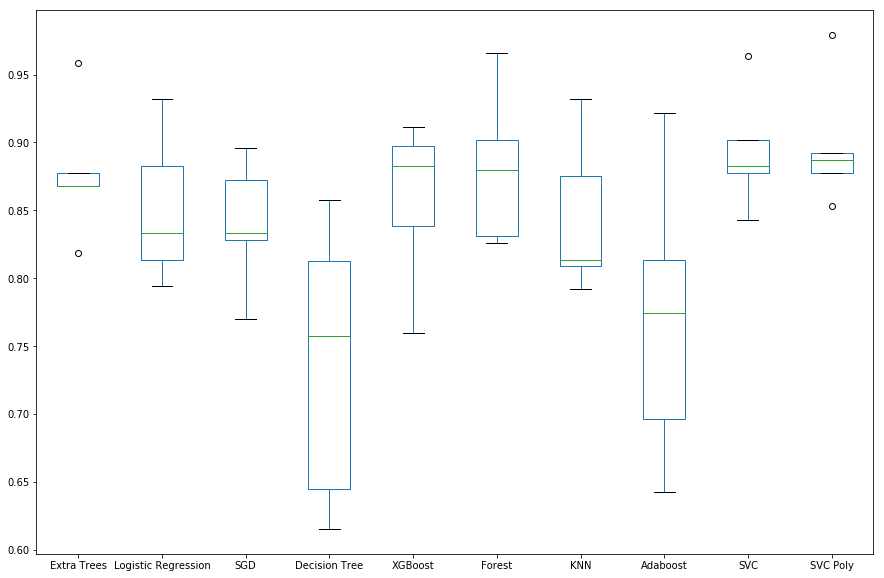

In [32]:
scores_df.plot(kind='box', figsize=(15,10))

### Hyperparameter Tuning

#### XGBoost

In [ ]:
param_grid = [
    {'max_depth':[3,6,10,15],
     'n_estimators':[10,100,500,1000],
     'gamma':[0,0.5,1]
    }
]

In [ ]:
grid_search = GridSearchCV(XGBClassifier(n_jobs=-1), param_grid, cv=5, scoring="roc_auc")
grid_search.fit(X_train1, y_train)

In [ ]:
cvres = grid_search.cv_results_

In [ ]:
cvres = grid_search.cv_results_
cv_results = sorted([(x,y) for x,y in zip(cvres["mean_test_score"],cvres["params"])],key=lambda x: x[0],reverse=True)
for AUC, params in cv_results:
    print(round(AUC,5), params)

In [ ]:
grid_search.best_score_

In [ ]:
grid_search.best_params_

#### Random Forest

In [ ]:
param_grid = [
    {'max_depth':[None,2,3,4],
     'n_estimators':[200,220,240,260],
     'bootstrap':[True,False],
    }
]

In [ ]:
grid_search_forest = GridSearchCV(RandomForestClassifier(n_jobs=-1), param_grid, cv=5, scoring="roc_auc")
grid_search_forest.fit(X_train1, y_train)

In [ ]:
grid_search_forest.best_score_

In [ ]:
cvres_forest = grid_search_forest.cv_results_
cv_results_forest = sorted([(x,y) for x,y in zip(cvres_forest["mean_test_score"],cvres_forest["params"])],key=lambda x: x[0],reverse=True)
for AUC, params in cv_results_forest[:10]:
    print(round(AUC,5), params)

In [ ]:
forest_final = grid_search_forest.best_estimator_

#### Extra Trees

In [ ]:
param_grid = [
    {'max_depth':[None,2,3,4],
     'n_estimators':[200,225,250,500,1000,1500],
     'bootstrap':[True,False],
    }
]

In [ ]:
grid_search_xtr = GridSearchCV(ExtraTreesClassifier(n_jobs=-1), param_grid, cv=5, scoring="roc_auc")
grid_search_xtr.fit(X_train1, y_train)

In [ ]:
grid_search_xtr.best_score_

In [ ]:
cvres_xtr = grid_search_xtr.cv_results_
cv_results_xtr = sorted([(x,y) for x,y in zip(cvres_xtr["mean_test_score"],cvres_xtr["params"])],key=lambda x: x[0],reverse=True)
for AUC, params in cv_results_xtr:
    print(round(AUC,5), params)

In [ ]:
final_model = grid_search_xtr.best_estimator_

### Test set score

In [ ]:
X_test_processed = pipe.transform(X_test)

In [ ]:
y_pred = forest_final.predict(X_test_processed)

In [ ]:
forest_final.score(X_test_processed, y_test)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(y_test, y_pred)

### Generate predictions on test_values dataset

In [ ]:
test_values = pd.read_csv('https://s3.amazonaws.com/drivendata/data/54/public/test_values.csv')

In [ ]:
test_values.info()

In [ ]:
test_values.loc[:,'thal'] = test_values.loc[:,'thal'].astype('category')
#test_values.loc[:,'chest_pain_type'] = test_values.loc[:,'chest_pain_type'].astype('category')

In [ ]:
test_ids = test_values['patient_id']
test_values = test_values.drop('patient_id',axis=1)

In [ ]:
test_values.info()

In [ ]:
input_ = pipe.transform(test_values)
input_.shape

In [ ]:
test_values.shape

In [ ]:
X_train.shape

In [ ]:
X_train2.shape

In [ ]:
forest_final.predict(input_)

In [ ]:
test_probas = forest_final.predict_proba(input_)

In [ ]:
test_probas

In [ ]:
heart_disease_probas = [y for x,y in test_probas]

In [ ]:
out_df = pd.DataFrame({'patient_id':test_ids,'heart_disease_present':heart_disease_probas})
out_df

In [ ]:
out_df.to_csv('submission3.csv',index=False)